In [ ]:
 %matplotlib inline


# Regresión Logística

Sobre el conjunto de datos total se toma el 20% de los ejemplos para prueba y se muestran los efectos de la variación del parámetro de regularización C. 
Al aplicar escalado (minmax) mejoró levemente la Exactitud. 


Automatically created module for IPython interactive environment
Calculando ...
Tardó 0.139s
             C  Accuracy  Precision    Recall  MeanCVAccu       Ord      Sexo   EdadIng    AñoIng    EscSec   Pública   Técnica    Ciudad     C1Lib     C1Reg    C1Prom     C2Lib     C2Reg    C2Prom
0       0.0001  0.711111   0.793103  0.410714    0.742593 -0.003431 -0.000493 -0.000545 -0.002197 -0.002366 -0.001747 -0.001678 -0.002018  0.003382 -0.003408 -0.003228  0.005995 -0.001755 -0.003487
1       0.0010  0.807407   0.857143  0.642857    0.803704 -0.029939 -0.004479 -0.004472 -0.019522 -0.021341 -0.014129 -0.015217 -0.017074  0.034614 -0.032415 -0.030565  0.059975 -0.016674 -0.033201
2       0.0100  0.859259   0.849057  0.803571    0.850000 -0.186756 -0.035200 -0.020976 -0.127812 -0.136777 -0.066884 -0.091698 -0.090886  0.272384 -0.238196 -0.214449  0.483958 -0.118489 -0.240491
3       0.1000  0.866667   0.851852  0.821429    0.851852 -0.676894 -0.204477 -0.003824 -0.476324 -0.342100 -0.1462

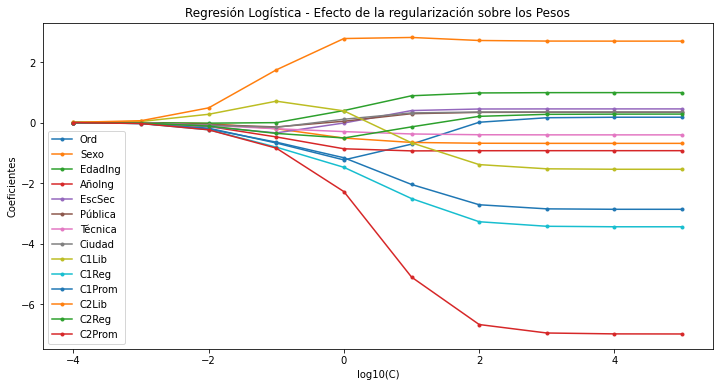

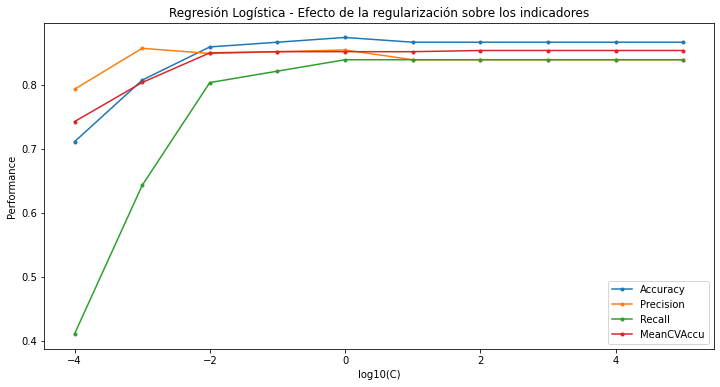

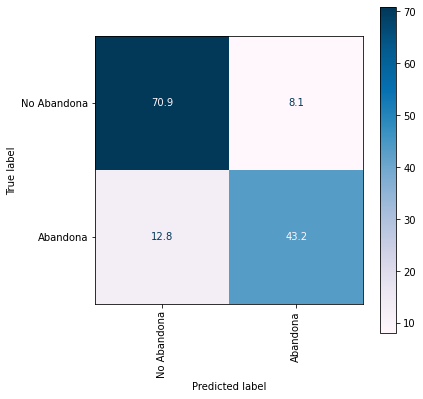

In [35]:
print(__doc__)
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from numpy import genfromtxt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import l1_min_c
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_openml
#from scipy.special import expit

def perf_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred) #TN,	FP,	FN,	TP
    #Accuracy = (TP+TN)/(TP+TN+FP+FN) = clf.score(X_test, y_test)
    accu = (cm[1,1] + cm[0,0])/(cm[1,1] + cm[0,0] + cm[0,1] + cm[1,0])
    #Precision=TP/(TP+FP)
    prec = cm[1,1]/(cm[1,1]+cm[0,1]) 
    #Recall=TP/(TP+FN)
    rec = cm[1,1]/(cm[1,1]+cm[1,0])
    return accu, prec, rec, cm  

#'Sexo',	'EdadIng',	'AñoIng',	'Pública',	'Técnica',	'C1lib',	'C1reg',	'C1prom',	'C2lib',	'C2reg',	'C2prom', 'Abandona?'
#Columnas 0 a 13 (excluyendo 3 y 6), características y resultado esperado
ds_floats = genfromtxt('dataset-sinnulos-completo.csv', dtype=float, delimiter=';', usecols = (0,1,2,4,5,7,8,9,10,11,12,13), skip_header=True,encoding='latin-1')

#'NomEscSec',	'CiudadAlu'
#Columnas 3 y 6, características categóricas
ds_strs = genfromtxt('dataset-sinnulos-completo.csv', dtype=str,  delimiter=';', usecols = (3,6),  skip_header=True, encoding='latin-1')

#se codifican las características categóricas (OneHotEncoder no tuvo buena performance)
enc = preprocessing.OrdinalEncoder()
X_cat = enc.fit_transform(ds_strs)

#enc = preprocessing.OneHotEncoder()
#X_esc_y_ciudad = enc.fit_transform(ds_strs).toarray()
#print(enc.get_feature_names())

#se toman las primeras 10 columnas numéricas
X_num = ds_floats[:,:11]
#se toman las predicciones
y = ds_floats[:,11]
#se agregan las dos columnas categoricas
X = np.c_[X_num[:,0:3], X_cat[:,0], X_num[:,[3,4]], X_cat[:,1], X_num[:,5:]] 
           
np.set_printoptions(precision=4, suppress=True, linewidth=1000)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
#print(X_scaled[:11,:]) #muestra primeras 10 filas

#particiona el dataset, reservando el 20% para prueba 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

print("Calculando ...")
start = time()

# l1_min_c, obtiene el valor min de C para l1 con liblinear, l1_min_c(X_train, y_train, loss='log') 
# tal que al menos un coef sea mayor que cero.
# np.logspace(2, 6, 15) genera 15 números que van de 1e0 a 1e6 
cs =  np.logspace(-4, 5, 10, base=10)
clf = linear_model.LogisticRegression(penalty='l2', max_iter=10000, solver='liblinear')

int_coefs = []
perf_coefs = []
cms = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X_train, y_train)
    #print(clf.n_iter_)
    y_pred=clf.predict(X_test)
    accu, prec, rec, cm = perf_metrics(y_test,y_pred)
    int_coef=np.r_[clf.intercept_.copy(), clf.coef_.ravel().copy()]    
    int_coefs.append(int_coef)
    cms.append(cm)
    mean_cvaccu = cross_val_score(clf, X_train, y_train, cv=5).mean()
    perf_coefs.append([accu, prec, rec, mean_cvaccu])
    
print("Tardó %0.3fs" % (time() - start))

resultados=np.c_[cs, perf_coefs, int_coefs]
nombres=['C', 'Accuracy', 'Precision','Recall','MeanCVAccu', 'Ord', 'Sexo',	'EdadIng',	'AñoIng',	'EscSec', 'Pública',	'Técnica', 'Ciudad',	'C1Lib',	'C1Reg',	'C1Prom',	'C2Lib',	'C2Reg',	'C2Prom'] 
rs=pd.DataFrame(data=resultados,columns=nombres)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(rs) 
print("")

int_coefs = np.array(int_coefs)
plt.figure(1,figsize=(12,6))
plt.plot(np.log10(cs), int_coefs, marker='.')
ymin, ymax = plt.ylim()
plt.xlabel('log10(C)')
plt.ylabel('Coeficientes')
plt.title('Regresión Logística - Efecto de la regularización sobre los Pesos')
plt.axis('tight')
plt.legend(nombres[-14:], loc="best", fontsize='medium')
plt.show()
print(" ")

plt.figure(2,figsize=(12,6))
plt.plot(np.log10(cs), perf_coefs, marker='.')
ymin, ymax = plt.ylim()
plt.xlabel('log10(C)')
plt.ylabel('Performance')
plt.title('Regresión Logística - Efecto de la regularización sobre los indicadores')
plt.axis('tight')
plt.legend(nombres[1:5], loc="best", fontsize='medium')
plt.show()
print(" ")

cms = np.array(cms)
disp = ConfusionMatrixDisplay(confusion_matrix=cms.mean(axis=0),  display_labels=['No Abandona', 'Abandona'])
disp.plot(xticks_rotation='vertical', values_format='.3g', cmap='PuBu')
disp.figure_.set_size_inches(6,6)
rs.to_excel("resultados.xlsx")  
#np.savetxt('resultados.csv', resultados, delimiter=';', header='C;Sexo;EdadIng;AñoIng;Pública;Técnica;C1lib;C1reg;C1prom;C2lib;C2reg;C2prom;EscSec;Ciudad;Ordenada')


#Persistencia del modelo
El siguiente código muestra como persistir el modelo elegido para C=100 usando *pickle*.

In [33]:
import pickle as p

clf = linear_model.LogisticRegression(penalty='l2', max_iter=10000, solver='liblinear')
clf.set_params(C=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accu, prec, rec, cm = perf_metrics(y_test,y_pred)
int_coef = np.r_[clf.intercept_.copy(), clf.coef_.ravel().copy()]    

print(f'Performance para C={clf.C}')
print(f'Exactitud={accu}; Precisión={prec}; Recall={rec};')
print(f'Pesos (w0 a w13):')
print(int_coef)

filename = 'reglog_saved_model.sav'
p.dump(clf, open(filename, 'wb'))

Performance para C=100
Exactitud=0.8666666666666667; Precisión=0.8392857142857143; Recall=0.8392857142857143;
Pesos (w0 a w13):
[ 0.0093 -0.6844  0.977  -0.9314  0.4467  0.3349 -0.4035  0.3465 -1.3897 -3.2766 -2.7161  2.7094  0.2045 -6.6722]


#Carga del modelo persistido
El siguiente código muestra como cargar el modelo persistido usando *pickle*.

In [34]:
loaded_clf = p.load(open(filename, 'rb'))

y_pred = loaded_clf.predict(X_test)
accu, prec, rec, cm = perf_metrics(y_test, y_pred)
int_coef = np.r_[loaded_clf.intercept_.copy(), loaded_clf.coef_.ravel().copy()]    

print(f'Performance para C={loaded_clf.C}')
print(f'Exactitud={accu}; Precisión={prec}; Recall={rec};')
print(f'Pesos (w0 a w13):')
print(int_coef)


Performance para C=100
Exactitud=0.8666666666666667; Precisión=0.8392857142857143; Recall=0.8392857142857143;
Pesos (w0 a w13):
[ 0.0093 -0.6844  0.977  -0.9314  0.4467  0.3349 -0.4035  0.3465 -1.3897 -3.2766 -2.7161  2.7094  0.2045 -6.6722]
